In [19]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt, matplotlib.image as mpimg
from sklearn import svm
import time
from sklearn.cluster import KMeans
import operator

In [20]:
data = pd.read_csv('./Datasets/fashion/fashion-mnist_train.csv')
data.head()
label = data.label
data=data.drop('label',axis=1)


In [21]:
def pca(A):
    M = np.mean(A.T, axis=1)
    C = A - M
    V = np.cov(C.T)
    values, vectors = np.linalg.eig(V)
    idx = values.argsort()[::-1]
    values = values[idx]
    vectors = vectors[:,idx]
    P_train = vectors.T.dot(A.T)
    return P_train.T,idx

In [22]:
data_pca,idx = pca(data)

In [23]:
train, test,train_labels, test_labels = train_test_split(data, label, train_size=0.8)
#taking top 200 dim
train_pca, test_pca, train_labels_pca, test_labels_pca = train_test_split(data_pca[:,0:200],label,train_size=0.8)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [24]:
test_b=test.copy()
train_b=train.copy()
test_b[test_b>0]=1
train_b[train_b>0]=1

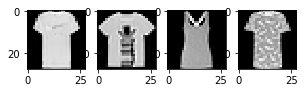

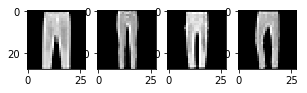

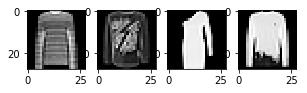

In [8]:
for x in range(0,3):
    train_0=data[label==x]
    data_new=[]
    for idx in train_0.index:
        val=train_0.loc[idx].values.reshape(28,28)
        data_new.append(val)
    plt.figure(figsize=(25,25))   
    for x in range(1,5):
        ax1=plt.subplot(1, 20, x)
        ax1.imshow(data_new[x],cmap='gray')

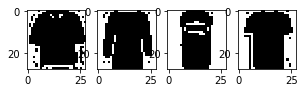

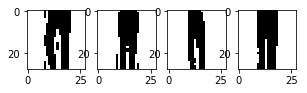

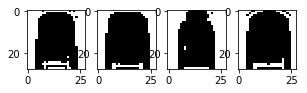

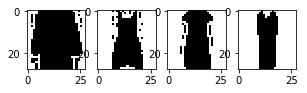

In [9]:

for x in range(0,4):
    train_0=train_b[train_labels==x]
    data_new=[]
    for idx in train_0.index:
        val=train_0.loc[idx].values.reshape(28,28)
        data_new.append(val)
    plt.figure(figsize=(25,25))   
    for x in range(1,5):
        ax1=plt.subplot(1, 20, x)
        ax1.imshow(data_new[x],cmap='binary')

In [25]:
#SVM
i=5000
st = time.time()
#original
model_grayscale = svm.SVC().fit(train[:i], train_labels[:i].values.ravel())
print("Time consumed to fit model: ",time.strftime("%H:%M:%S", time.gmtime(time.time()-st)))
print(model_grayscale.score(test,test_labels))

#binary image
st = time.time()
model_binary = svm.SVC().fit(train_b[:i], train_labels[:i].values.ravel())
print("Time consumed to fit model: ",time.strftime("%H:%M:%S", time.gmtime(time.time()-st)))
print(model_binary.score(test_b,test_labels))

#pca
st = time.time()
model_pca = svm.SVC().fit(train_pca[:i], train_labels_pca[:i].values.ravel())
print("Time consumed to fit model: ",time.strftime("%H:%M:%S", time.gmtime(time.time()-st)))
print(model_pca.score(test_pca,test_labels_pca))


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Time consumed to fit model:  00:00:47
0.10125


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Time consumed to fit model:  00:00:08
0.8040833333333334


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Time consumed to fit model:  00:00:14
0.10216666666666667


In [26]:
#initialization of clusters(mode=1 for random, mode=2 for kmeans) 
#2 stopping criterias: no of iterations(n_iter) and change in log-likelihood(change)
def gmm(X,n_clusters,n_iter,change,mode):
    
    #initializing clusters randomly
    clusters=[]
    if(mode==1):    
        for i in range(n_clusters):
            means = np.random.rand(X.shape[1])
            covariances = np.identity(X.shape[1],dtype=np.float64)
            clusters.append({'alphas':1.0/n_clusters,'means':means,'covariances':covariances})
    elif(mode==2):
        kmeans = KMeans().fit(X)
        means = kmeans.cluster_centers_
        for i in range(n_clusters):
            #means = np.random.rand(X.shape[1])
            covariances = np.identity(X.shape[1],dtype=np.float64)
            clusters.append({'alphas':1.0/n_clusters,'means':means[i],'covariances':covariances})
    else:
        print("Incorrect mode")
        return
        
    likelihoods = [0]
    
    for i in range(n_iter):
        
        
        denominator_bayes = np.zeros((X.shape[0],1),dtype=np.float64)
        for c in clusters:
            alphas = c['alphas']
            means = c['means']
            covariances = c['covariances']
            
            normal_prob = np.diagonal(1 / ((2 * np.pi) ** (X.shape[1] / 2) * np.linalg.det(covariances) ** 0.5) * np.exp(-0.5 * np.dot(np.dot((X-means), np.linalg.inv(covariances)), (X-means).T))).reshape(-1, 1)
            new_nk = (alphas*normal_prob).astype(np.float64)
            
            for j in range(X.shape[0]):
                denominator_bayes[j] += new_nk[j]
            
            c['new_nk'] = new_nk
            c['denominator_bayes'] = denominator_bayes
            
        for c in clusters:
            c['new_nk'] /= c['denominator_bayes']  #all newk's are updated now
            
        
        for c in clusters:
            new_nk = c['new_nk']
            new_covariance = np.zeros((X.shape[1],X.shape[1]))
            new_alphas = np.sum(new_nk,axis=0)/float(X.shape[0])
            new_means = np.sum(new_nk*X,axis=0)/np.sum(new_nk,axis=0)
            
            for j in range(X.shape[0]):
                new_covariance += new_nk[j]*np.dot((X[j] - new_means).reshape(-1, 1),((X[j] - new_means).reshape(-1, 1)).T)
            
            new_covariance /= np.sum(new_nk, axis=0)
            
            c['alphas'] = new_alphas
            c['means'] = new_means
            c['covariances'] = new_covariance
            
        likelihoods.append(np.sum(np.log(np.array([c['denominator_bayes'] for c in clusters]))))
        print('Iter: ', i + 1, 'Likelihood: ', likelihoods[-1])
        
        #another stopping criteria in terms of likelihood
        if(abs(likelihoods[-1]-likelihoods[-2])<change):
            print('Stopping criteria reached without iterations getting over')
            break
            
    return clusters


In [12]:
clus = gmm(data_pca[:1000,:5].astype('float64'),10,10,0.001,1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:2022: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Iter:  1 Likelihood:  -inf
Iter:  2 Likelihood:  nan
Iter:  3 Likelihood:  nan
Iter:  4 Likelihood:  nan
Iter:  5 Likelihood:  nan
Iter:  6 Likelihood:  nan
Iter:  7 Likelihood:  nan
Iter:  8 Likelihood:  nan
Iter:  9 Likelihood:  nan
Iter:  10 Likelihood:  nan


In [42]:
data.values[:200].astype('float64').shape

(200, 784)

In [21]:
data.values[:,0:200].shape

(42000, 200)

In [40]:
data_pca[:,0:5].shape

(42000, 5)

In [13]:
def ED(x1, x2, length):
    distance = 0
    for x in range(length):
        distance += np.square(x1[x] - x2[x])
    return np.sqrt(distance)

def knn_algo(x,test,k):
    length = len(test)-1
    distances={}
    #sort={}
    for i in range(len(x)):
        dist = ED(x.iloc[i],test,length)
        #print(dist)
        distances[i]=dist
    sortdist = sorted(distances.items(), key=operator.itemgetter(1))
    neighbors = []
    for i in range(k):
        neighbors.append(sortdist[i][0])
    Votes={}
    for i in range(len(neighbors)):
        response = x.iloc[neighbors[i]][-1] #taking response will handle even for multiclass
        if response in Votes:
            Votes[response] += 1
        else:
            Votes[response] = 1
    sortvotes = sorted(Votes.items(), key=operator.itemgetter(1), reverse=True)
    return sortvotes[0][0]

def pred_knn(x_train,x_test,k):
    output = []
    for i in range(len(x_test)):
        print(i)
        output.append(knn_algo(x_train,x_test.iloc[i],k))
    return output

In [29]:
train['target'] = train_labels
test['target'] = test_labels

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [30]:
predictions = pred_knn(train[:1000],test[:20],10)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [31]:
predictions

[7, 0, 9, 7, 8, 8, 1, 1, 9, 4, 4, 7, 7, 7, 2, 5, 1, 0, 2, 4]

In [32]:
test[:20]

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,target
54440,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
23348,0,0,0,0,1,0,0,0,0,19,...,5,0,0,0,0,0,0,0,0,0
36107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
25773,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
30841,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,4,0,8
42699,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
15571,0,0,0,0,0,0,0,0,0,16,...,0,0,0,0,0,0,0,0,0,1
13484,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
41147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
4126,0,0,0,0,0,0,0,0,0,43,...,105,137,122,137,50,0,0,0,0,0


In [95]:
test.shape

(8400, 785)

In [78]:
a=[[2,3],[4,5]]
b=[[6],[7]]

In [80]:
np.append(train[:2],test_labels[:2],axis=1)

ValueError: all the input arrays must have same number of dimensions

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [92]:
train_labels

5869     9
13140    9
34632    3
24063    0
35345    4
26356    4
12154    3
7658     9
4294     1
16511    9
16686    4
20075    0
32864    4
32330    6
688      1
4523     1
11874    5
30137    0
19621    2
41639    0
29236    9
35516    3
34901    6
11805    8
23866    9
16211    3
17887    7
14326    7
18572    2
14862    8
        ..
16452    8
31012    8
24151    3
36708    6
5272     9
3288     7
12403    9
17157    8
31876    8
15348    8
33225    6
40794    8
36586    1
31188    8
30055    2
26570    3
39218    2
7431     0
8329     6
1769     6
37359    9
8817     8
5510     0
3390     9
33891    1
39523    8
436      7
8565     3
17843    1
21019    8
Name: label, Length: 33600, dtype: int64